# Temporal Difference Methods
- 발표자: 석사과정 최선묵

**Temporal Difference method** is a Reinforcement Learning (RL) algorithm.
- Similar to Monte Carlo methods, it updates Q-table by **sampling experiences** from the environment.
- Unlike Monte Carlo methods, it uses **bootstrapping target** which allows us to update the table **at each time transition**.

## Monte Carlo (MC) methods

Let's recall the udpate equation of MC methods.
$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \Big[ \, G_t - Q(S_t,A_t)\, \Big]$$
This method is based on the fact that the return $G_t$ is an unbiased estimator of $q_\pi(s,a)$ because
$$ q_\pi(s,a) = \mathbb{E}_\pi\big[G_t | S_t=s, A_t=a\big].$$
However, this update equation requires us to wait until the end of an episode since the return can be computed when an episode is finished.

## Temporal Difference (TD) methods

TD methods instead use Bellman equations, Bellman expectation equation or Bellman optimality equation.
Recall the equations.

$$ q_\pi(s,a) = \mathbb{E}_\pi\big[R_{t+1}+\gamma q_\pi(S_{t+1},A_{t+1}) \, | \, S_t=s,A_t=a \,\big] $$
$$ q_\ast(s,a) = \mathbb{E}\big[R_{t+1} + \gamma \max_{a'} q_\ast(S_{t+1},a') \,|\,S_t=s,A_t=a \big] $$

### Sarsa
Sarsa method uses the update equation which is based on the Bellman expectation equation:
$$Q(S_t, A_t) \leftarrow Q(S_t,A_t) + \alpha \Big[ \, R_{t+1} + \gamma Q(S_{t+1}, A_{t+1}) - Q(S_t,A_t) \, \Big]$$
From the Bellman expectation equation, the unbiased estimator of $q_\pi(s,a)$ is $R_{t+1}+\gamma q_\pi(S_{t+1},A_{t+1})$.
However, we do not have access to the true action-value function,
we use the current estimate $Q(S_{t+1}, A_{t+1})$ instead of $q_\pi(S_{t+1},A_{t+1})$.
When its update is based on an existing estimate, we say that it is a `bootstrapping` method. The bootstrapping method also makes the TD target biased. 

### Q-learning
Q-learning method uses the update equation which is based on the Bellman optimality equation:
$$Q(S_t, A_t) \leftarrow Q(S_t,A_t) + \alpha \Big[ \, R_{t+1} + \gamma \max_aQ(S_{t+1}, a) - Q(S_t,A_t) \, \Big]$$
Similar to Sarsa, since the true optimal action-value function $q_\ast(S_{t+1},a)$ is unknown, the current estimate is used in the update equation.
Hence, the target is again biased.

A pseudo code of TD methods is the following.

<center><img src="./TD_Algorithm.png" width="900" height="600"></center>

## On-policy v.s. Off-policy

- **Target Policy** : the policy an agent is trying to learn (agent learns value function for this policy)
    - The policy that chooses an action in the target of value functions.
- **Behavior Policy** : the policy being used by an agent for choosing actions and generating data.
    - The policy that chooses an action in the environment to take next steps.

We should be able to distinguish two policies above. We say a method is on-policy or off-policy according to the conditions below.
- On-Policy : target policy = behavior policy
- Off-Policy : target policy $\neq$ behavior policy

## Cliff Walking

- [Gym Environment](https://www.gymlibrary.dev/environments/toy_text/cliff_walking/)
- This gridworld example compares Sarsa and Q-learning, highlighting the difference between on-policy (Sarsa) and off-policy (Q-learning) methods.

<center><img src="./cliff_walking.png" width="600" height="250"></center>

- **Observation space** : $4 \times 12$ matrix, with (using NumPy matrix indexing):
    - `[3,0]` as the start at bottom-left
    - `[3,11]` as the goal at bottom-right
    - `[3,1..10]` as the cliff at bottom-center
- **Action space**
    - `0`: Move up
    - `1`: Move right
    - `2`: Move down
    - `3`: Move left
- **Reward** : Each time step incurs -1 reward, and stepping into the cliff incurs -100 reward.
- **Transition Probability** : Deterministic. No extra randomness in transitions.

If the agent steps on the cliff, it returns to the start (the episode is not terminated). An episode terminates when the agent reaches the goal.

In [1]:
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt

In [2]:
## Epsilon-greedy policy

def get_action(Q_table, state, epsilon):
    '''
    Q_table : a numpy array of the shape (|S|, |A|)
    '''
    tmp = random.random()

    if tmp < epsilon: 
        # random action with probability epsilon
        action_num = Q_table.shape[1]
        return np.random.randint(action_num)
    
    # greedy action with probability 1 - epsilon
    return np.argmax(Q_table[state])

## SARSA

- $Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma Q(S',A') - Q(S,A)]$

In [3]:
EPSILON = 0.1
MAX_EPISODE = 1000
GAMMA = 1
alpha = 0.4

def learn_by_sarsa(env, EPSILON, MAX_EPISODE, GAMMA, alpha, print_log=True):

    Q_table = np.zeros((env.observation_space.n, env.action_space.n))

    sarsa_rewards = []
    
    for episode in range(MAX_EPISODE):
        
        terminated = False
        epi_reward = 0

        # Initialize the environment
        state, info = env.reset()
        action = get_action(Q_table, state, EPSILON)
        
        while not terminated:
            next_state, reward, terminated, truncated, info = env.step(action)
            next_action = get_action(Q_table, next_state, EPSILON)
            Q_table[state, action] += alpha * (reward + GAMMA*Q_table[next_state, next_action] - Q_table[state, action])
            state = next_state
            action = next_action
            epi_reward += reward

        sarsa_rewards.append(epi_reward)

        if print_log:
            if episode % 200 == 0: # print log
                print("episode_num:" + str(episode))
                Q_table_transform1 = np.argmax(Q_table, axis=1)
                Q_table_transform1 = np.reshape(Q_table_transform1, (4,12))
                print(Q_table_transform1)
        
    return sarsa_rewards, Q_table

sarsa_rewards, Q_table1 = learn_by_sarsa(gym.make("CliffWalking-v0"), EPSILON, MAX_EPISODE, GAMMA, alpha)

episode_num:0
[[3 1 1 1 1 1 1 1 1 1 1 2]
 [2 2 2 2 2 2 2 2 2 2 2 3]
 [1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0]]
episode_num:200
[[1 1 1 1 1 1 1 1 2 2 2 2]
 [0 0 0 1 1 0 0 0 1 1 2 2]
 [0 1 1 0 0 0 0 1 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
episode_num:400
[[1 1 1 1 1 1 1 1 0 1 1 2]
 [1 1 0 0 1 1 0 1 0 0 1 2]
 [0 0 0 0 0 0 0 1 1 3 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
episode_num:600
[[1 1 1 1 1 1 1 1 1 1 2 2]
 [1 1 0 1 1 1 0 1 1 1 1 2]
 [0 0 0 3 0 0 0 1 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
episode_num:800
[[1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 1 1 1 1 1 1 0 0 1 2]
 [0 3 0 3 0 0 0 1 0 3 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [4]:
print('Final Policy at each state')
print('Actions -- 0: Up, 1: Right, 2: Down, 3: Left')
print('-'*40)
print(np.reshape(np.argmax(Q_table1, axis=1), (4,12)))

Final Policy at each state
Actions -- 0: Up, 1: Right, 2: Down, 3: Left
----------------------------------------
[[1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 1 1 0 1 1 1 0 3 1 2]
 [0 0 0 3 0 0 3 0 0 3 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


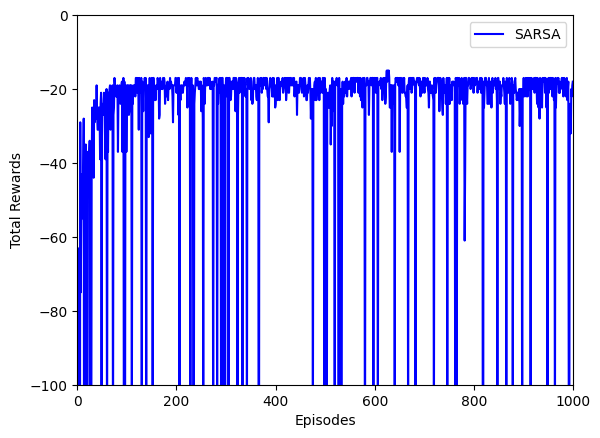

In [5]:
plt.plot(np.arange(MAX_EPISODE), sarsa_rewards, 'b-', label='SARSA')
plt.axis([0,1000, -100,0])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()

## Q-learning

- $\displaystyle Q(S,A) \leftarrow Q(S,A) + \alpha [R + \gamma \max_a Q(S',a) - Q(S,A)]$

In [6]:
EPSILON = 0.1
MAX_EPISODE = 1000
GAMMA = 1
alpha = 0.4

def learn_by_qlearning(env, EPSILON, MAX_EPISODE, GAMMA, alpha, print_log=True):

    Q_table = np.zeros((env.observation_space.n, env.action_space.n))

    qlearning_rewards = []

    for episode in range(MAX_EPISODE):
        
        terminated = False
        epi_reward = 0
        
        # Initialize the environment
        state, info = env.reset()
        
        while not terminated:
            action = get_action(Q_table, state, EPSILON)
            next_state, reward, terminated, truncated, info = env.step(action)
            Q_table[state, action] += alpha * (reward + GAMMA*np.max(Q_table[next_state]) - Q_table[state, action])
            state = next_state
            epi_reward += reward
        
        qlearning_rewards.append(epi_reward)

        if print_log:    
            if episode % 200 == 0: # print log
                print("episode_num:" + str(episode))
                Q_table_transform2 = np.argmax(Q_table, axis=1)
                Q_table_transform2 = np.reshape(Q_table_transform2, (4,12))
                print(Q_table_transform2)

    return qlearning_rewards, Q_table

qlearning_rewards, Q_table2 = learn_by_qlearning(gym.make("CliffWalking-v0"), EPSILON, MAX_EPISODE, GAMMA, alpha)

episode_num:0
[[2 2 2 2 2 3 3 3 2 0 2 0]
 [1 0 0 0 0 1 2 3 1 1 1 1]
 [1 0 0 0 0 0 0 2 2 2 2 3]
 [1 0 0 0 0 0 0 0 0 0 0 0]]
episode_num:200
[[0 3 2 1 1 1 1 0 2 1 1 2]
 [1 3 1 2 1 2 0 1 2 1 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
episode_num:400
[[2 0 1 1 1 1 1 1 1 2 2 2]
 [2 2 1 1 1 1 2 2 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
episode_num:600
[[0 1 1 1 0 1 0 1 1 0 1 2]
 [0 1 2 1 1 1 2 2 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
episode_num:800
[[3 1 2 1 0 1 0 3 1 1 1 2]
 [3 1 2 2 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [7]:
print('Final Policy at each state')
print('Actions -- 0: Up, 1: Right, 2: Down, 3: Left')
print('-'*40)
print(np.reshape(np.argmax(Q_table2, axis=1), (4,12)))

Final Policy at each state
Actions -- 0: Up, 1: Right, 2: Down, 3: Left
----------------------------------------
[[2 0 0 3 1 2 2 0 1 1 1 2]
 [1 2 1 1 2 1 2 1 1 1 2 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


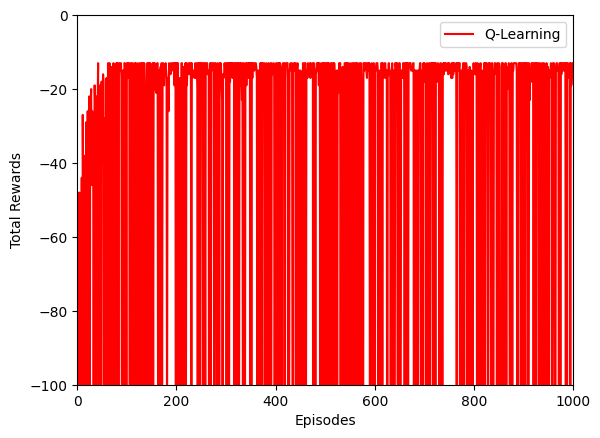

In [8]:
plt.plot(np.arange(MAX_EPISODE), qlearning_rewards, 'r-', label='Q-Learning')
plt.axis([0, 1000, -100,0])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()

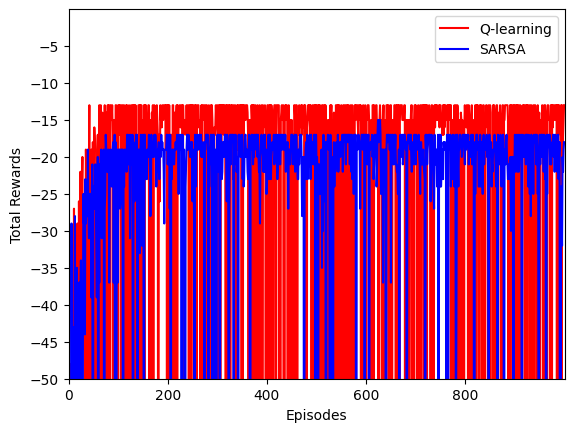

In [9]:
plt.plot(np.arange(MAX_EPISODE), qlearning_rewards, 'r-', label='Q-learning')
plt.plot(np.arange(MAX_EPISODE), sarsa_rewards, 'b-', label='SARSA')
plt.axis([0,1000, -50,0])
plt.xticks(np.arange(0,1000,200))
plt.yticks(np.arange(-50,0,5))
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()

## Expected Sarsa
- Expected Sarsa like Q-learning algorithm that uses **the expected value** over next state-action pairs instead of the maximization. 
- Given the next state, $S_{t+1}$, this algorithm moves **deterministically** in the same direction as Sarsa moves **in expectation**. 
- Expected Sarsa **costs more** than the original Sarsa, but it **eliminates the variance** due to the random selection of $A_{t+1}$.

The update equation of SARSA is the following.
<center><img src="./expected_sarsa.png" width="800" height="120"></center>

In [10]:
EPSILON = 0.1
MAX_EPISODE = 1000
GAMMA = 1
alpha = 0.4

def learn_by_exp_sarsa(env, EPSILON, MAX_EPISODE, GAMMA, alpha, print_log=True):

    Q_table = np.zeros((env.observation_space.n, env.action_space.n))

    exp_sarsa_rewards = []

    for episode in range(MAX_EPISODE):
        
        terminated = False
        epi_reward = 0

        # Initialize the environment
        state, info = env.reset()
        
        
        while not terminated:
            action = get_action(Q_table, state, EPSILON)
            next_state, reward, terminated, truncated, info = env.step(action)
            
            policy = np.ones(env.action_space.n)*(EPSILON/env.action_space.n)
            argmax = np.argmax(Q_table[next_state])
            policy[argmax] += 1-EPSILON
            
            Q_table[state, action] += alpha * (reward + GAMMA*np.dot(policy,Q_table[next_state]) - Q_table[state, action])
            state = next_state
            epi_reward += reward

        exp_sarsa_rewards.append(epi_reward)

        if print_log:
            if episode % 200 == 0: # print log
                print("episode_num: " + str(episode))
                Q_table_transform3 = np.argmax(Q_table, axis=1)
                Q_table_transform3 = np.reshape(Q_table_transform3, (4,12))
                print(Q_table_transform3)

    return exp_sarsa_rewards, Q_table

exp_sarsa_rewards, Q_table3 = learn_by_exp_sarsa(gym.make("CliffWalking-v0"), EPSILON, MAX_EPISODE, GAMMA, alpha)

episode_num: 0
[[3 0 0 1 2 2 2 2 2 2 2 1]
 [2 2 2 2 2 1 1 1 1 1 2 3]
 [1 0 0 0 0 0 0 0 0 0 0 3]
 [1 0 0 0 0 0 0 0 0 0 0 0]]
episode_num: 200
[[0 1 1 2 1 2 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 1 0 1 0 1 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
episode_num: 400
[[3 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
episode_num: 600
[[1 1 3 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]
episode_num: 800
[[0 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


In [11]:
print('Final Policy at each state')
print('Actions -- 0: Up, 1: Right, 2: Down, 3: Left')
print('-'*40)
print(np.reshape(np.argmax(Q_table3, axis=1), (4,12)))

Final Policy at each state
Actions -- 0: Up, 1: Right, 2: Down, 3: Left
----------------------------------------
[[1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


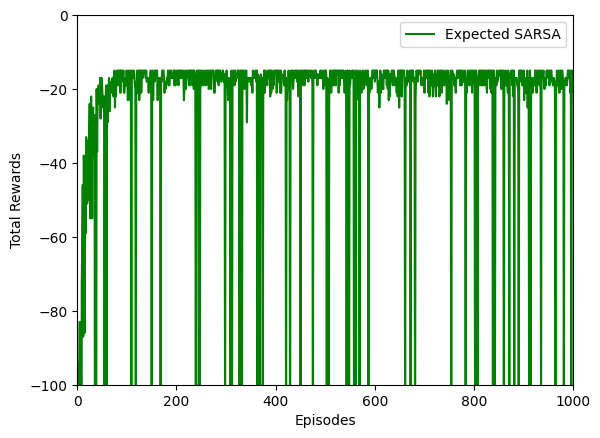

In [12]:
plt.plot(np.arange(MAX_EPISODE), exp_sarsa_rewards, 'g-', label='Expected SARSA')
plt.axis([0,1000, -100,0])
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()

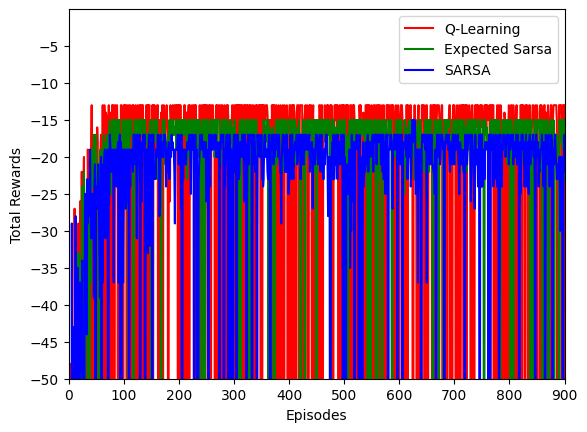

In [13]:
plt.plot(np.arange(MAX_EPISODE), qlearning_rewards, 'r-', label='Q-Learning')
plt.plot(np.arange(MAX_EPISODE), exp_sarsa_rewards, 'g-', label='Expected Sarsa')
plt.plot(np.arange(MAX_EPISODE), sarsa_rewards, 'b-', label='SARSA')
plt.axis([0,500, -50,0])
plt.xticks(np.arange(0,1000,100))
plt.yticks(np.arange(-50,0,5))
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.legend()
plt.show()

In [14]:
EPSILON = 0.1
MAX_EPISODE = 1000
GAMMA = 1
alpha = 0.4
AVERAGE = 1000

env = gym.make("CliffWalking-v0")
sarsa_rewards_arr = np.zeros((AVERAGE, MAX_EPISODE))
qlearning_rewards_arr = np.zeros((AVERAGE, MAX_EPISODE))
exp_sarsa_rewards_arr = np.zeros((AVERAGE, MAX_EPISODE))

Q_table1_arr = np.zeros((AVERAGE, env.observation_space.n, env.action_space.n))
Q_table2_arr = np.zeros((AVERAGE, env.observation_space.n, env.action_space.n))
Q_table3_arr = np.zeros((AVERAGE, env.observation_space.n, env.action_space.n))

for i in range(AVERAGE):
    sarsa_rewards, Q_table1 = learn_by_sarsa(gym.make("CliffWalking-v0"), EPSILON, MAX_EPISODE, GAMMA, alpha, print_log=False)
    sarsa_rewards_arr[i] = sarsa_rewards
    Q_table1_arr[i] = Q_table1

for j in range(AVERAGE):
    qlearning_rewards, Q_table2 = learn_by_qlearning(gym.make("CliffWalking-v0"), EPSILON, MAX_EPISODE, GAMMA, alpha, print_log=False)
    qlearning_rewards_arr[j] = qlearning_rewards
    Q_table2_arr[j] = Q_table2

for k in range(AVERAGE):
    exp_sarsa_rewards, Q_table3 = learn_by_exp_sarsa(gym.make("CliffWalking-v0"), EPSILON, MAX_EPISODE, GAMMA, alpha, print_log=False)
    exp_sarsa_rewards_arr[k] = exp_sarsa_rewards
    Q_table3_arr[k] = Q_table3

sarsa_mean_rewards = np.mean(sarsa_rewards_arr, axis=0)
qlearning_mean_rewards = np.mean(qlearning_rewards_arr, axis=0)
exp_sarsa_mean_rewards = np.mean(exp_sarsa_rewards_arr, axis=0)

Q_table1_mean = np.mean(Q_table1_arr, axis=0)
Q_table2_mean = np.mean(Q_table2_arr, axis=0)
Q_table3_mean = np.mean(Q_table3_arr, axis=0)

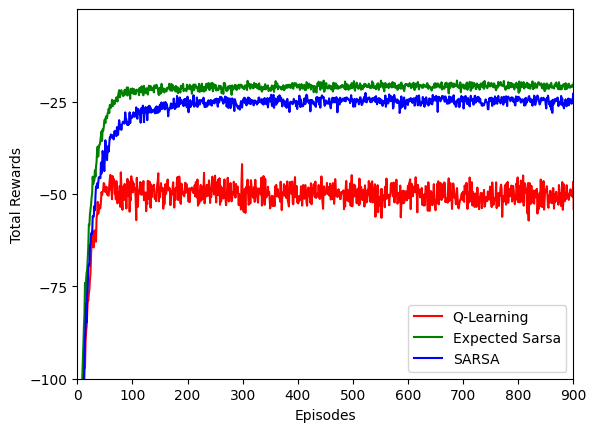

In [15]:
plt.plot(np.arange(MAX_EPISODE), qlearning_mean_rewards, 'r-', label='Q-Learning')
plt.plot(np.arange(MAX_EPISODE), exp_sarsa_mean_rewards, 'g-', label='Expected Sarsa')
plt.plot(np.arange(MAX_EPISODE), sarsa_mean_rewards, 'b-', label='SARSA')
plt.legend()
plt.axis([0,500, -100,0])
plt.xticks(np.arange(0,1000,100))
plt.yticks(np.arange(-100,0,25))
plt.xlabel('Episodes')
plt.ylabel('Total Rewards')
plt.show()

In [16]:
print('Final Policy at each state using SARSA')
print('Actions -- 0: Up, 1: Right, 2: Down, 3: Left')
print('-'*40)
print(np.reshape(np.argmax(Q_table1_mean, axis=1), (4,12)))
print('\n')
print('Final Policy at each state using Q-learning')
print('Actions -- 0: Up, 1: Right, 2: Down, 3: Left')
print('-'*40)
print(np.reshape(np.argmax(Q_table2_mean, axis=1), (4,12)))
print('\n')
print('Final Policy at each state using Expected Sarsa')
print('Actions -- 0: Up, 1: Right, 2: Down, 3: Left')
print('-'*40)
print(np.reshape(np.argmax(Q_table3_mean, axis=1), (4,12)))
print('\n')


Final Policy at each state using SARSA
Actions -- 0: Up, 1: Right, 2: Down, 3: Left
----------------------------------------
[[1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


Final Policy at each state using Q-learning
Actions -- 0: Up, 1: Right, 2: Down, 3: Left
----------------------------------------
[[1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


Final Policy at each state using Expected Sarsa
Actions -- 0: Up, 1: Right, 2: Down, 3: Left
----------------------------------------
[[1 1 1 1 1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 1 1 1 1 2]
 [0 0 0 0 0 0 0 0 0 1 1 2]
 [0 0 0 0 0 0 0 0 0 0 0 0]]


